# Optimization 2: Algorithms and Constraints

Florian Oswald
Sciences Po, 2019

## Bracketing

* A derivative-free method for *univariate* $f$
* works only on **unimodal** $f$
* (Draw choosing initial points and where to move next)

![](bracketing.png)

## The Golden Ratio or Bracketing Search for 1D problems

* A derivative-free method
* a Bracketing method
	* find the local minimum of $f$ on $[a,b]$
	* select 2 interior points $c,d$ such that $a<c<d<b$
		* $f(c) \leq f(d) \implies$ min must lie in $[a,d]$. replace $b$ with $d$, start again with $[a,d]$
		* $f(c) > f(d) \implies$ min must lie in $[c,b]$. replace $a$ with $c$, start again with $[c,b]$
	* how to choose $b,d$ though?
	* we want the length of the interval to be independent of whether we replace upper or lower bound
	* we want to reuse the non-replaced point from the previous iteration. 
	* these imply the golden rule:
	* new point $x_i = a + \alpha_i (b-a)$, where $\alpha_1 = \frac{3-\sqrt{5}}{2},\alpha_2=\frac{\sqrt{5}-1}{2}$
	* $\alpha_2$ is known as the *golden ratio*, well known for it's role in renaissance art.

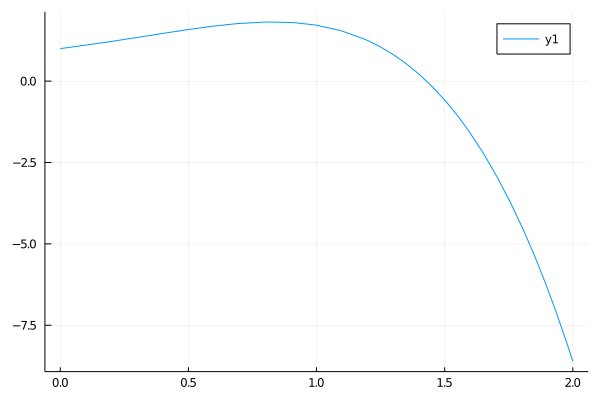

In [31]:
using Plots
using Optim
gr()
f(x) = exp(x) - x^4
plot(f,0,2)

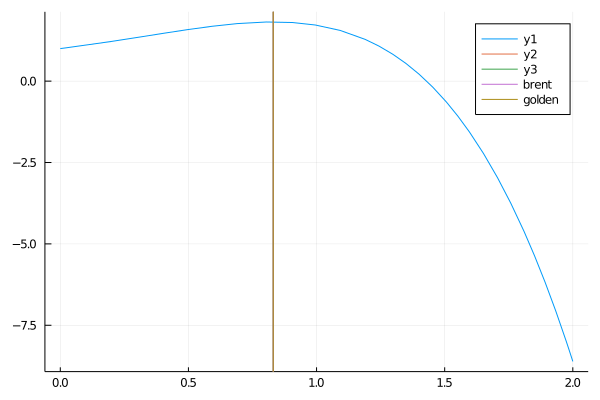

In [34]:
minf(x) = -f(x)
brent = optimize(minf,0,2,Brent())
golden = optimize(minf,0,2,GoldenSection())
vline!([Optim.minimizer(brent)],label = "brent")
vline!([Optim.minimizer(golden)], label = "golden")

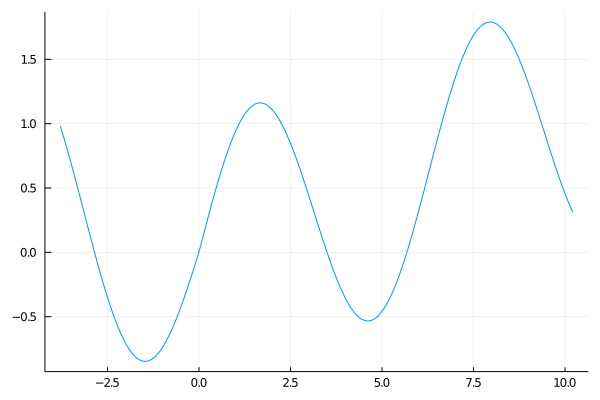

In [27]:
f2 = x->sin(x) + 0.1*abs(x)
x_arr = collect(range(3π/2-8.5, stop=3π/2+5.5, length=151))
y_arr = f2.(x_arr) 
plot(x_arr,y_arr,legend = false)

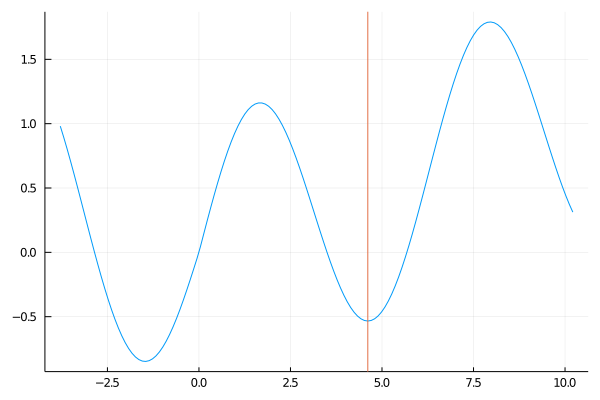

In [28]:
ob = optimize(f2,1,5,Brent())
vline!([Optim.minimizer(ob)])

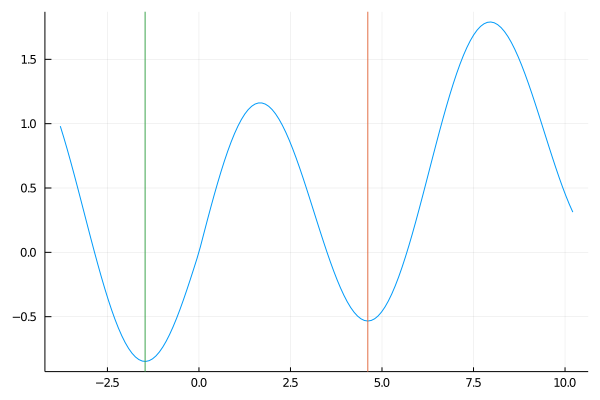

In [29]:
ob = optimize(f2,-2.5,2.5,Brent())
vline!([Optim.minimizer(ob)])

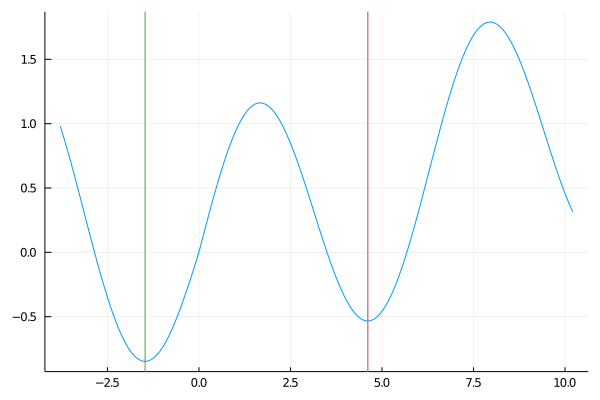

In [30]:
ob = optimize(f2,-2.5,10,Brent())
vline!([Optim.minimizer(ob)])

### Bisection Methods

* Root finding: `Roots.jl`
* Root finding in multivariate functions: [`IntervalRootFinding.jl`](https://github.com/JuliaIntervals/IntervalRootFinding.jl/)

In [2]:
using Roots
# find the zeros of this function:
f(x) = exp(x) - x^4
## bracketing
fzero(f, 8, 9)      # 8.613169456441398
fzero(f, -10, 0) # -0.8155534188089606

LoadError: ArgumentError: Package Roots not found in current path:
- Run `import Pkg; Pkg.add("Roots")` to install the Roots package.


In [3]:
using IntervalRootFinding, IntervalArithmetic
-10..10

LoadError: ArgumentError: Package IntervalRootFinding not found in current path:
- Run `import Pkg; Pkg.add("IntervalRootFinding")` to install the IntervalRootFinding package.


In [4]:
X = IntervalBox(1..3, 2..4)

LoadError: UndefVarError: .. not defined

In [5]:
a = @interval(0.1, 0.3)
b = @interval(0.3, 0.6)
a + b

LoadError: LoadError: UndefVarError: @interval not defined
in expression starting at In[5]:1

In [6]:
rts = roots(x->x^2 - 2, -10..10, IntervalRootFinding.Bisection)

LoadError: UndefVarError: .. not defined

## Rosenbrock Banana and Optim.jl

* We can supply the objective function and - depending on the solution algorithm - the gradient and hessian as well.

In [7]:
using Optim
using OptimTestProblems
for (name, prob) in MultivariateProblems.UnconstrainedProblems.examples
   println(name)
end

┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1278


LoadError: ArgumentError: Package OptimTestProblems not found in current path:
- Run `import Pkg; Pkg.add("OptimTestProblems")` to install the OptimTestProblems package.


In [8]:
rosenbrock = MultivariateProblems.UnconstrainedProblems.examples["Rosenbrock"]

LoadError: UndefVarError: MultivariateProblems not defined

## Comparison Methods

* We will now look at a first class of algorithms, which are very simple, but sometimes a good starting point.
* They just *compare* function values.
* *Grid Search* : Compute the objective function at $G=\{x_1,\dots,x_N\}$ and pick the highest value of $f$. 
	* This is very slow.
	* It requires large $N$.
	* But it's robust (will find global optimizer for large enough $N$)

In [9]:
# grid search on rosenbrock
grid = collect(-1.0:0.1:3);
grid2D = [[i;j] for i in grid,j in grid];
val2D = map(rosenbrock.f,grid2D);
r = findmin(val2D);
println("grid search results in minimizer = $(grid2D[r[2]])")

LoadError: UndefVarError: rosenbrock not defined

## Local Descent Methods

* Applicable to multivariate problems
* We are searching for a *local model* that provides some guidance in a certain region of $f$ over **where to go to next**.
* Gradient and Hessian are informative about this.

### Local Descent Outline

All descent methods follow more or less this structure. At iteration $k$,

1. Check if candidate $\mathbf{x}^{(k)}$ satisfies stopping criterion:
    * if yes: stop
    * if no: continue
2. Get the local *descent direction*  $\mathbf{d}^{(k)}$, using gradient, hessian, or both.
3. Set the *step size*, i.e. the length of the next step, $\alpha^k$
4. Get the next candidate via
    $$\mathbf{x}^{(k+1)} \longleftarrow \alpha^k\mathbf{d}^{(k)}$$

### The Line Search Strategy

* An algorithm from the line search class  chooses a direction $\mathbf{d}^{(k)} \in \mathbb{R}^n$ and searches along that direction starting from the current iterate $x_k \in \mathbb{R}^n$ for a new iterate $x_{k+1} \in \mathbb{R}^n$ with a lower function value.
* After deciding on a direction $\mathbf{d}^{(k)}$, one needs to decide the *step length* $\alpha$ to travel by solving
	$$ \min_{\alpha>0} f(x_k + \alpha \mathbf{d}^{(k)}) $$
* In practice, solving this exactly is too costly, so algos usually generate a sequence of trial values $\alpha$ and pick the one with the lowest $f$.

In [10]:
# https://github.com/JuliaNLSolvers/LineSearches.jl 
using LineSearches

algo_hz = Optim.Newton(linesearch = HagerZhang())    # Both Optim.jl and IntervalRootFinding.jl export `Newton`
res_hz = Optim.optimize(rosenbrock.f, rosenbrock.g!, rosenbrock.h!, rosenbrock.initial_x, method=algo_hz)

LoadError: ArgumentError: Package LineSearches not found in current path:
- Run `import Pkg; Pkg.add("LineSearches")` to install the LineSearches package.


### The Trust Region Strategy

* First choose max step size, then the direction
* Finds the next step $\mathbf{x}^{(k+1)}$ by minimizing a model of $\hat{f}$ over a *trust region*, centered on $\mathbf{x}^{(k)}$
    * 2nd order Tayloer approx of $f$ is common.
* Radius $\delta$ of trust region is changed based on how well $\hat{f}$ fits $f$ in trust region.
* Get $\mathbf{x'}$ via
    $$
    \begin{aligned}
    \min_{\mathbf{x'}} &\quad \hat{f}(\mathbf{x'}) \\
    \text{subject to } &\quad \Vert \mathbf{x}-\mathbf{x'} \leq \delta \Vert
    \end{aligned}
    $$

In [11]:
# Optim.jl has a TrustRegion for Newton (see below for Newton's Method)
NewtonTrustRegion(; initial_delta = 1.0, # The starting trust region radius
                    delta_hat = 100.0, # The largest allowable trust region radius
                    eta = 0.1, #When rho is at least eta, accept the step.
                    rho_lower = 0.25, # When rho is less than rho_lower, shrink the trust region.
                    rho_upper = 0.75) # When rho is greater than rho_upper, grow the trust region (though no greater than delta_hat).
res = Optim.optimize(rosenbrock.f, rosenbrock.g!, rosenbrock.h!, rosenbrock.initial_x, method=NewtonTrustRegion())

LoadError: UndefVarError: rosenbrock not defined

### Stopping criteria

1. maximum number of iterations reached
2. absolute improvement $|f(x) - f(x')| \leq \epsilon$
3. relative improvement $|f(x) - f(x')| / |f(x)| \leq \epsilon$
4. Gradient close to zero $|g(x)| \approx 0$


### Gradient Descent

* Here we define
    $$\mathbf{g}^{(k)} = \nabla f(\mathbf{d}^{(k)})$$
* And our descent becomes
    $$\mathbf{d}^{(k)} = -\nabla \frac{\mathbf{g}^{(k)} }{\Vert\mathbf{g}^{(k)}\Vert }$$
* Minimizing wrt step size results in a jagged path (each direction is orthogonal to previous direction!)
    $$\alpha^{(k)} = \arg \min{\alpha} f(\mathbf{x}^{(k)} + \alpha \mathbf{d}^{(k)}) $$
* *Conjugate* Gradient avoids this issue.

In [12]:
# Optim.jl again
GradientDescent(; alphaguess = LineSearches.InitialPrevious(),
                  linesearch = LineSearches.HagerZhang(),
                  P = nothing,
                  precondprep = (P, x) -> nothing)

LoadError: UndefVarError: LineSearches not defined

In [13]:
# there is a dedicated LineSearch package: https://github.com/JuliaNLSolvers/LineSearches.jl
GD = optimize(rosenbrock.f, rosenbrock.g!,[0.0, 0.0],GradientDescent())
GD1 = optimize(rosenbrock.f, rosenbrock.g!,[0.0, 0.0],GradientDescent(),Optim.Options(iterations=5000))
GD2 = optimize(rosenbrock.f, rosenbrock.g!,[0.0, 0.0],GradientDescent(),Optim.Options(iterations=50000))

println("gradient descent = $GD")
println("\n")
println("gradient descent 2 = $GD1")
println("\n")
println("gradient descent 3 = $GD2")

LoadError: UndefVarError: rosenbrock not defined

## Second Order Methods

### Newton's Method

* We start with a 2nd order Taylor approx over x at step $k$:
    $$q(x) = f(x^{(k)}) + (x - x^{(k)}) f'(x^{(k)}) + \frac{(x - x^{(k)})^2}{2}f''(x^{(k)})$$
* We set find it's root and rearrange to find the next step $k+1$:
    $$
    \begin{aligned}
    \frac{\partial q(x)}{\partial x} &= f'(x^{(k)}) + (x - x^{(k)}) f''(x^{(k)}) = 0 \\
    x^{(k+1)} &= x^{(k)} - \frac{f'(x^{(k)})}{f''(x^{(k)})}
    \end{aligned}
    $$

* The same argument works for multidimensional functions by using Hessian and Gradient
* We would get a descent $\mathbf{d}^k$ by setting:
    $$\mathbf{d}^k = -\frac{\mathbf{g}^{k}}{\mathbf{H}^{k}}$$
* There are several options to avoid (often costly) computation of the Hessian $\mathbf{H}$:
1. Quasi-Newton updates $\mathbf{H}$ starting from identity matrix
2. Broyden-Fletcher-Goldfarb-Shanno (BFGS) does better with approx linesearch
3. L-BFGS is the limited memory version for large problems

In [14]:
optimize(rosenbrock.f, rosenbrock.g!, rosenbrock.h!, [0.0, 0.0], Optim.Newton(),Optim.Options(show_trace=true))

LoadError: UndefVarError: rosenbrock not defined

In [15]:
@show optimize(rosenbrock.f, rosenbrock.g!, rosenbrock.h!,  [-1.0, 3.0], BFGS());

LoadError: UndefVarError: rosenbrock not defined

In [16]:
# low memory BFGS
@show optimize(rosenbrock.f, rosenbrock.g!, rosenbrock.h!,  [0.0, 0.0], LBFGS());

LoadError: UndefVarError: rosenbrock not defined

## Direct Methods

* No derivative information is used - *derivative free*
* If it's very hard / impossible to provide gradient information, this is our only chance.
* Direct methods use other criteria than the gradient to inform the next step (and ulimtately convergence).

### Cyclic Coordinate Descent -- Taxicab search

* We do a line search over each dimension, one after the other
* *taxicab* because the path looks like a NYC taxi changing direction at each block.
* given $\mathbf{x}^{(1)}$, we proceed
    $$
    \begin{aligned}
    \mathbf{x}^{(2)} &= \arg \min_{x_1} f(x_1,x_2^{(1)},\dots,x_n^{(1)}) \\
    \mathbf{x}^{(3)} &= \arg \min_{x_2} f(x_1^{(2)},x_2,x_3^{(2)}\dots,x_n^{(2)}) \\    
    \end{aligned}
    $$
* unfortunately this can easily get stuck because it can only move in 2 directions.

In [17]:
# start to setup a basis function, i.e. unit vectors to index each direction:
basis(i, n) = [k == i ? 1.0 : 0.0 for k in 1 : n]
function cyclic_coordinate_descent(f, x, ε) 
    Δ, n = Inf, length(x)
    while abs(Δ) > ε
        x′ = copy(x) 
            for i in 1 : n
                d = basis(i, n)
                x = line_search(f, x, d) 
            end
        Δ = norm(x - x′) 
    end
    return x 
end  

cyclic_coordinate_descent (generic function with 1 method)

### General Pattern Search

* We search according to an arbitrary *pattern* $\mathcal{P}$ of candidate points, anchored at current guess $\mathbf{x}$.
* With step size $\alpha$ and set $\mathcal{D}$ of directions
    $$ \mathcal{P} = {\mathbf{x} + \alpha \mathbf{d} \text{ for } \mathbf{d}\in\mathcal{D} }$$
* Convergence is guaranteed under conditions:
    * $\mathcal{D}$ must be a positive spanning set: at least one $\mathbf{d}\in\mathcal{D}$ has a non-zero gradient.

In [18]:
function generalized_pattern_search(f, x, α, D, ε, γ=0.5) 
    y, n = f(x), length(x)
    evals = 0
    while α > ε
        improved = false
        for (i,d) in enumerate(D)
            x′ = x + α*d 
            y′ = f(x′) 
            evals += 1
            if y′ < y
                x, y, improved = x′, y′, true
                D = pushfirst!(deleteat!(D, i), d) 
                break
            end 
        end
        if !improved 
            α *= γ
        end 
    end
    println("$evals evaluations")
    return x 
end

generalized_pattern_search (generic function with 2 methods)

In [19]:
D = [[1,0],[0,1],[-1,-0.5]]
D = [[1,0],[0,1]]
y=generalized_pattern_search(rosenbrock.f,zeros(2),0.8,D,1e-6 )

LoadError: UndefVarError: rosenbrock not defined

## Bracketing for Multidimensional Problems: Nelder-Mead

* The Goal here is to find the simplex containing the local minimizer $x^*$
* In the case where $f$ is n-D, this simplex has $n+1$ vertices
* In the case where $f$ is 2-D, this simplex has $2+1$ vertices, i.e. it's a triangle.
* The method proceeds by evaluating the function at all $n+1$ vertices, and by replacing the worst function value with a new guess.
* this can be achieved by a sequence of moves:
	* reflect
	* expand
	* contract
	* shrink
	movements.



<div class="center" style="width: auto; margin-left: auto; margin-right: auto;"> ![](figs/optimization/neldermeadsteps.jpg) </div>

* this is a very popular method. The matlab functions `fmincon` and `fminsearch` implements it.
* When it works, it works quite fast.
* No derivatives required.

In [20]:
nm=optimize(rosenbrock.f, [0.0, 0.0], NelderMead());
nm.minimizer

LoadError: UndefVarError: rosenbrock not defined

* But.


## Bracketing for Multidimensional Problems: Comment on Nelder-Mead

> Lagarias et al. (SIOPT, 1999):
At present there is no function in any dimension greater than one, for which the original Nelder-Mead algorithm has been proved to converge to a minimizer.

>Given all the known inefficiencies and failures of the Nelder-Mead algorithm [...], one might wonder why it is used at all, let alone why it is so extraordinarily popular.




## things to read up on

* Divided Rectangles (DIRECT)
* simulated annealing and other stochastic gradient methods



## Stochastic Optimization Methods

* Gradient based methods like steepest descent may be susceptible to getting stuck at local minima.
* Randomly shocking the value of the descent direction may be a solution to this.
* For example, one could modify our gradient descent from before to become


 $$\mathbf{x}^{(k+1)} \longleftarrow \mathbf{x}^{(k)} +\alpha^k\mathbf{g}^{(k)} + \mathbf{\varepsilon}^{(k)}$$

* where $\mathbf{\varepsilon}^{(k)} \sim N(0,\sigma_k^2)$, decreasing with $k$.
* This *stochastic gradient descent* is often used when training neural networks.


### Simulated Annealing

* We specify a *temperature* that controls the degree of randomness.
* At first the temperature is high, letting the search jump around widely. This is to escape local minima.
* The temperature is gradually decreased, reducing the step sizes. This is to find the local optimimum in the *best* region.
* At every iteration $k$, we accept new point $\mathbf{x'}$ with

$$
\Pr(\text{accept }\mathbf{x'}) = \begin{cases}
1 & \text{if }\Delta y \leq0 \\
\min(e^{\Delta y / t},1) & \text{if }\Delta y > 0 
\end{cases}
$$

* here $\Delta y = f(\mathbf{x'}) - f(\mathbf{x})$, and $t$ is the *temperature*.
* $\Pr(\text{accept }\mathbf{x'})$ is called the **Metropolis Criterion**, building block of *Accept/Reject* algorithms.

In [21]:
# f: function
# x: initial point
# T: transition distribution
# t: temp schedule, k_max: max iterations
function simulated_annealing(f, x, T, t, k_max) 
    y = f(x)
    ytrace = zeros(typeof(y),k_max)
    x_best, y_best = x, y 
    for k in 1 : k_max
        x′ = x + rand(T)
        y′ = f(x′)
        Δy = y′ - y
        if Δy ≤ 0 || rand() < exp(-Δy/t(k))
            x, y = x′, y′ 
        end
        if y′ < y_best
            x_best, y_best = x′, y′
        end 
        ytrace[k] = y_best
    end
    return x_best,ytrace
end

simulated_annealing (generic function with 1 method)

In [22]:
function ackley(x, a=20, b=0.2, c=2π) 
    d = length(x)
    return -a*exp(-b*sqrt(sum(x.^2)/d)) - exp(sum(cos.(c*xi) for xi in x)/d) + a + exp(1)
end
using Plots
gr()
surface(-30:0.1:30,-30:0.1:30,(x,y)->ackley([x, y]),cbar=false)

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


Your GR installation is incomplete. Rerun build step for GR package.


ERROR: LoadError: LoadError: InitError: Evaluation into the closed module `GR` breaks incremental compilation because the side effects will not be permanent. This is likely due to some other module mutating `GR` with `eval` during precompilation - don't do this.
Stacktrace:
 [1] eval at ./boot.jl:331 [inlined]
 [2] __init__() at /Users/74097/.julia/packages/GR/G9I5v/src/GR.jl:280
 [3] _include_from_serialized(::String, ::Array{Any,1}) at ./loading.jl:697
 [4] _require_search_from_serialized(::Base.PkgId, ::String) at ./loading.jl:782
 [5] _require(::Base.PkgId) at ./loading.jl:1007
 [6] require(::Base.PkgId) at ./loading.jl:928
 [7] require(::Module, ::Symbol) at ./loading.jl:923
 [8] include(::Function, ::Module, ::String) at ./Base.jl:380
 [9] include at ./Base.jl:368 [inlined]
 [10] include(::String) at /Users/74097/.julia/packages/Plots/SIQaY/src/Plots.jl:1
 [11] top-level scope at /Users/74097/.julia/packages/Plots/SIQaY/src/Plots.jl:216
 [12] include(::Function, ::Module, ::Strin

LoadError: Failed to precompile Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] to /Users/74097/.julia/compiled/v1.5/Plots/ld3vC_Rf1Lv.ji.

In [23]:
p = Any[]
using Distributions
gr()
niters = 1000
temps = (1,10,25)
push!(p,[plot(x->i/x,1:1000,title = "tmp $i",lw=2,ylims = (0,1),leg = false) for i in (1,10,25)]...)
for sig in (1,5,25), t1 in (1,10,25)
    y = simulated_annealing(ackley,[15,15],MvNormal(2,sig),x->t1/x,1000)[2][:]
    push!(p,plot(y,title = "sig = $sig",leg=false,lw=1.5,color="red",ylims = (0,20)))
end
plot(p...,layout = (4,3))

LoadError: ArgumentError: Package Distributions not found in current path:
- Run `import Pkg; Pkg.add("Distributions")` to install the Distributions package.


# Constraints

Recall our core optimization problem:

$$ 
\min_{x\in\mathbb{R}^n} f(x)  \text{ s.t. } x \in \mathcal{X}
$$

* Up to now, the feasible set was $\mathcal{X} \in \mathbb{R}^n$. 
* In **constrained problems** $\mathcal{X}$ is a subset thereof.
* We already encountered *box constraints*, e.g. $x \in [a,b]$.
* Sometimes the contrained solution coincides with the unconstrained one, sometimes it does not.
* There are *equality constraints* and *inequality constraints*.


## Lagrange Multipliers

* Used to optimize a function subject to equality constraints.

$$
\begin{aligned}
\min_x & f(x) \\
\text{subject to } & h(x) = 0
\end{aligned}
$$

where both $f$ and $h$ have continuous partial derivatives.

* We look for contour lines of $f$ that are aligned to contours of $h(x) = 0$.

In other words, we want to find the best $x$ s.t. $h(x) = 0$ and we have

$$
\nabla f(x) = \lambda \nabla h(x)
$$

for some *Lagrange Mutliplier* $\lambda$
* Notice that we need the scalar $\lambda$ because the magnitudes of the gradients may be different.
* We therefore form the the **Lagrangian**:

$$
\mathcal{L}(x,\lambda) = f(x) - \lambda h(x)
$$

### Example

Suppose we have

$$
\begin{aligned}
\min_x & -\exp\left( -\left( x_1 x_2 - \frac{3}{2} \right)^2 - \left(x_2 - \frac{3}{2}\right)^2 \right) \\
\text{subject to } & x_1 - x_2^2 = 0
\end{aligned}
$$

We form the Lagrangiagn:

$$
\mathcal{L}(x_1,x_2,\lambda) = -\exp\left( -\left( x_1 x_2 - \frac{3}{2} \right)^2 - \left(x_2 - \frac{3}{2}\right)^2 \right) - \lambda(x_1 - x_2^2)
$$

Then we compute the gradient wrt to $x_1,x_2,\lambda$, set to zero and solve.

In [24]:
gr()
f(x1,x2) = -exp.(-(x1.*x2 - 3/2).^2 - (x2-3/2).^2)
c(x1) = sqrt(x1)
x=0:0.01:3.5
contour(x,x,(x,y)->f(x,y),lw=1.5,levels=[collect(0:-0.1:-0.85)...,-0.887,-0.95,-1])
plot!(c,0.01,3.5,label="",lw=2,color=:black)
scatter!([1.358],[1.165],markersize=5,markercolor=:red,label="Constr. Optimum")

LoadError: UndefVarError: gr not defined

* If we had multiple constraints ($l$), we'd just add them up to get

$$
\mathcal{L}(\mathbf{x},\mathbf{\lambda}) = f(\mathbf{x}) - \sum_{i=1}^l \lambda_i h_i(\mathbf{x})
$$

## Inequality Constraints

Suppose now we had

$$
\begin{aligned}
\min_\mathbf{x} & f(\mathbf{x}) \\
\text{subject to } & g(\mathbf{x}) \leq 0
\end{aligned}
$$

which, if the solution lies right on the constraint *boundary*, means that

$$
\nabla f - \mu \nabla g = 0
$$

for some scalar $\mu$ - as before. 

* In this case, we say the **constraint is active**.
* In the opposite case, i.e. the solution lies **inside** the contrained region, we way the contraint is **inactive**. 
* In that case, we are back to an *unconstrained* problem, look for $\nabla f = 0$, and set $\mu=0$.



In [25]:
# the blue area shows the FEASIBLE SET
contour(x,x,(x,y)->f(x,y),lw=1.5,levels=[collect(0:-0.1:-0.85)...,-0.887,-0.95,-1])
plot!(c,0.01,3.5,label="",lw=2,color=:black,fill=(0,0.5,:blue))
scatter!([1.358],[1.165],markersize=5,markercolor=:red,label="Constr. Optimum")

LoadError: UndefVarError: contour not defined

In [26]:
# the blue area shows the FEASIBLE SET
# NOW THE CONSTRAINT IS INACTIVE OR SLACK!
c2(x1) = 1+sqrt(x1)
contour(x,x,(x,y)->f(x,y),lw=1.5,levels=[collect(0:-0.1:-0.85)...,-0.887,-0.95,-1])
plot!(c2,0.01,3.5,label="",lw=2,color=:black,fill=(0,0.5,:blue))
scatter!([1],[1.5],markersize=5,markercolor=:red,label="Unconstr. Optimum")

LoadError: UndefVarError: contour not defined

## Infinity Step

* We could do an **infinite step** to avoid *infeasible points*:

$$
\begin{aligned}
f_{\infty\text{-step}} &= \begin{cases}
f(\mathbf{x}) & \text{if } g(\mathbf{x}) \leq 0 \\
\infty & \text{else. } 
\end{cases}\\
 &= f(\mathbf{x}) + \infty (g(\mathbf{x} > 0)
\end{aligned}
$$

* Unfortunately, this is discontinous and non-differentiable, i.e. hard to handle for algorithms.
* Instead, we use a *linear penalty* $\mu g(\mathbf{x})$ on the objective if the constraint is violated.
* The penalty provides a lower bound to $\infty$:

$$
\mathcal{L}(\mathbf{x},\mu) = f(\mathbf{x}) + \mu g(\mathbf{x})
$$

* We can get back the infinite step by maximizing the penalty:

$$
f_{\infty\text{-step}} = \max_{\mu\geq 0} \mathcal{L}(\mathbf{x},\mu)
$$

* Every infeasible $\mathbf{x}$ returns $\infty$, all others return $f(\mathbf{x})$

## Kuhn-Karush-Tucker (KKT)

* Our problem thus becomes

$$
\min_\mathbf{x} \max_{\mu\geq 0} \mathcal{L}(\mathbf{x},\mu)
$$

* This is called the **primal problem**. Optimizing this requires:


1. $g(\mathbf{x}^*) \leq 0$. Point is feasible.
2. $\mu \geq 0$. Penalty goes into the right direction. *Dual feasibility*.
3. $\mu g(\mathbf{x}^*) = 0$. Feasible point on the boundary has $g(\mathbf{x}) = 0$, otherwise $g(\mathbf{x}) < 0$ and $\mu =0$.
4. $\nabla f(\mathbf{x}^*) - \mu \nabla g(\mathbf{x}^*) = 0$. With an active constraint, we want parallel contours of objective and constraint. When inactive, our optimum just has $\nabla f(\mathbf{x}^*) = 0$, which means $\mu = 0$.


The preceding four conditions are called the Kuhn-Karush-Tucker (KKT) conditions. In the above order, and in general terms, they are:

1. Feasibility
2. Dual Feasibility
3. Complementary Slackness
4. Stationarity.

The KKT conditions are the FONCs for problems with smooth constraints.

## Duality

We can combine equality and inequality constraints:

$$
\mathcal{L}(\mathbf{x},\mathbf{\lambda},\mathbf{\mu}) = f(\mathbf{x}) + \sum_{i} \lambda_i h_i(\mathbf{x}) + \sum_j \mu_j g_j(\mathbf{x})
$$

where, notice, we reverted the sign of $\lambda$ since this is unrestricted.

* The Primal problem is identical to the original problem and just as difficult to solve:

$$
\min_\mathbf{x} \max_{\mathbf{\mu}\geq 0,\mathbf{\lambda}} \mathcal{L}(\mathbf{x},\mathbf{\mu},\mathbf{\lambda})
$$

* The Dual problem reverses min and max:

$$
\max_{\mathbf{\mu}\geq 0,\mathbf{\lambda}} \min_\mathbf{x}  \mathcal{L}(\mathbf{x},\mathbf{\mu},\mathbf{\lambda})
$$



### Dual Values

* The *max-min-inequality* states that for any function $f(a,b)$

$$
\max_\mathbf{a} \min_\mathbf{b} f(\mathbf{a},\mathbf{b}) \leq \min_\mathbf{b} \max_\mathbf{a} f(\mathbf{a},\mathbf{b}) 
$$

* Hence, the solution to the dual is a lower bound to the solution of the primal problem.
* The solution to the *dual function*, $\min_\mathbf{x}  \mathcal{L}(\mathbf{x},\mathbf{\mu},\mathbf{\lambda})$ is the min of a collection of linear functions, and thus always concave.
* It is easy to optimize this.
* In general, solving the dual is easy whenever minimizing $\mathcal{L}$ wrt $x$ is easy.

## Penalty Methods

* We can convert the constrained problem back to unconstrained by adding penalty terms for constraint violoations.
* A simple method could just count the number of violations:

$$
p_\text{count}(\mathbf{x}) = \sum_{i} (h_i(\mathbf{x}) \neq 0 ) + \sum_j  (g_j(\mathbf{x} > 0)
$$

* and add this to the objective in an *unconstrained* problem with penalty $\rho > 0$

$$
\min_\mathbf{x} f(\mathbf{x}) + \rho p_\text{count}(\mathbf{x})
$$

* One can choose the penalty function: for example, a quadratic penaly will produce a smooth objective function
* Notice that $\rho$ needs to become very large sometimes here.

## Augmented Lagrange Method

* This is very similar, but specific to equality constraints.

## Interior Point Method

* Also called *barrier method*.
* These methods make sure that the search point remains always feasible.
* As one approaches the constraint boundary, the barrier function goes to infinity. Properties:

1. $p_\text{barrier}(\mathbf{x})$ is continuous
2. $p_\text{barrier}(\mathbf{x})$ is non negative
3. $p_\text{barrier}(\mathbf{x})$ goes to infinitey as one approaches the constraint boundary

### Barriers

* Inverse Barrier

$$
p_\text{barrier}(\mathbf{x}) = -\sum_i \frac{1}{g_i(\mathbf{x})}
$$

* Log Barrier

$$
p_\text{barrier}(\mathbf{x}) = -\sum_i \begin{cases}\log(-g_i(\mathbf{x})) & \text{if } g_i(\mathbf{x}) \geq -1 \\
0& \text{else.} 
\end{cases}
$$

* The approach is as before, one transforms the problem to an unconstrained one and increases $\rho$ until convergence:

$$
\min_\mathbf{x} f(\mathbf{x}) + \frac{1}{\rho} p_\text{barrier}(\mathbf{x})
$$


### Examples

$$ 
\min_{x \in \mathbb{R}^2} \sqrt{x_2} \text{ subject to }\begin{array}{c} \\
 x_2 \geq 0 \\
 x_2 \geq (a_1 x_1 + b_1)^3 \\
x_2 \geq (a_2 x_1 + b_2)^3 
\end{array}
$$



## Constrained Optimisation with [`NLopt.jl`](https://github.com/JuliaOpt/NLopt.jl)

* We need to specify one function for each objective and constraint.
* Both of those functions need to compute the function value (i.e. objective or constraint) *and* it's respective gradient. 
* `NLopt` expects contraints **always** to be formulated in the format 
	$$ g(x) \leq 0 $$
     where $g$ is your constraint function
* The constraint function is formulated for each constraint at $x$. it returns a number (the value of the constraint at $x$), and it fills out the gradient vector, which is the partial derivative of the current constraint wrt $x$.
* There is also the option to have vector valued constraints, see the documentation.
* We set this up as follows:

In [27]:
using NLopt

count = 0 # keep track of # function evaluations

function myfunc(x::Vector, grad::Vector)
    if length(grad) > 0
        grad[1] = 0
        grad[2] = 0.5/sqrt(x[2])
    end

    global count
    count::Int += 1
    println("f_$count($x)")

    sqrt(x[2])
end

function myconstraint(x::Vector, grad::Vector, a, b)
    if length(grad) > 0
        grad[1] = 3a * (a*x[1] + b)^2
        grad[2] = -1
    end
    (a*x[1] + b)^3 - x[2]
end

opt = Opt(:LD_MMA, 2)
lower_bounds!(opt, [-Inf, 0.])
xtol_rel!(opt,1e-4)

min_objective!(opt, myfunc)
inequality_constraint!(opt, (x,g) -> myconstraint(x,g,2,0), 1e-8)
inequality_constraint!(opt, (x,g) -> myconstraint(x,g,-1,1), 1e-8)

(minfunc,minx,ret) = NLopt.optimize(opt, [1.234, 5.678])
println("got $minfunc at $minx after $count iterations (returned $ret)")

┌ Info: Precompiling NLopt [76087f3c-5699-56af-9a33-bf431cd00edd]
└ @ Base loading.jl:1278


f_1([1.234, 5.678])
f_2([0.8787394664016357, 5.551370325142423])
f_3([0.8262160034228196, 5.043903787432386])
f_4([0.4739440370386794, 4.0767726724255375])
f_5([0.35389779634506047, 3.0308503583016])
f_6([0.33387310647853335, 1.9717933962872487])
f_7([0.3333337209575201, 1.0450874902862517])
f_8([0.33333357431034494, 0.4695027039311135])
f_9([0.3333332772332185, 0.3057923933552822])
f_10([0.33333339455750244, 0.2963215980646768])
f_11([0.3333333342139688, 0.29629628951338166])
got 0.5443310477213124 at [0.3333333342139688, 0.29629628951338166] after 11 iterations (returned XTOL_REACHED)


## NLopt: Rosenbrock

* Let's tackle the rosenbrock example again.
* To make it more interesting, let's add an inequality constraint.
	$$ \min_{x\in \mathbb{R}^2} (1-x_1)^2  + 100(x_2-x_1^2)^2  \text{  subject to  } 0.8 - x_1^2 -x_2^2 \geq 0 $$
* in `NLopt` format, the constraint is $x_1 + x_2 - 0.8 \leq 0$

In [28]:
function rosenbrockf(x::Vector,grad::Vector)
    if length(grad) > 0
	    grad[1] = -2.0 * (1.0 - x[1]) - 400.0 * (x[2] - x[1]^2) * x[1]
	    grad[2] = 200.0 * (x[2] - x[1]^2)
    end
    return (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
end
function r_constraint(x::Vector, grad::Vector)
    if length(grad) > 0
	grad[1] = 2*x[1]
	grad[2] = 2*x[2]
	end
	return x[1]^2 + x[2]^2 - 0.8
end
opt = Opt(:LD_MMA, 2)
lower_bounds!(opt, [-5, -5.0])
min_objective!(opt,(x,g) -> rosenbrockf(x,g))
inequality_constraint!(opt, (x,g) -> r_constraint(x,g))
ftol_rel!(opt,1e-9)
NLopt.optimize(opt, [-1.0,0.0])

(0.07588358473630112, [0.7247018361820217, 0.5242206107649053], :FTOL_REACHED)

## JuMP.jl

* Introduce [`JuMP.jl`](https://github.com/JuliaOpt/JuMP.jl)
* JuMP is a mathematical programming interface for Julia. It is like AMPL, but for free and with a decent programming language.
* The main highlights are:
	* It uses automatic differentiation to compute derivatives from your expression.
	* It supplies this information, as well as the sparsity structure of the Hessian to your preferred solver.
	* It decouples your problem completely from the type of solver you are using. This is great, since you don't have to worry about different solvers having different interfaces.
	* In order to achieve this, `JuMP` uses [`MathProgBase.jl`](https://github.com/JuliaOpt/MathProgBase.jl), which converts your problem formulation into a standard representation of an optimization problem.
* Let's look at the readme
* The technical citation is Lubin et al <cite data-cite=JuMP></cite>



## JuMP: Quick start guide

* this is form the [quick start guide](http://www.juliaopt.org/JuMP.jl/v0.19.0/)
* please check the docs, they are excellent.

### Step 1: create a model

* A model collects variables, objective function and constraints.
* it defines a specific solver to be used.
* JuMP makes it very easy to [swap out solver backends](http://www.juliaopt.org/JuMP.jl/dev/installation/) - This is very valuable!

In [29]:
using JuMP
using GLPK
model = Model(with_optimizer(GLPK.Optimizer))
@variable(model, 0 <= x <= 2)
@variable(model, 0 <= y <= 30)
# next, we set an objective function
@objective(model, Max, 5x + 3 * y)

# maybe add a constraint called "con":
@constraint(model, con, 1x + 5y <= 3);


┌ Info: Precompiling JuMP [4076af6c-e467-56ae-b986-b466b2749572]
└ @ Base loading.jl:1278


LoadError: ArgumentError: Package GLPK not found in current path:
- Run `import Pkg; Pkg.add("GLPK")` to install the GLPK package.


* At this stage `JuMP` has a mathematical representation of our model internalized
* The `MathProgBase` machinery knows now exactly how to translate that to different solver interfaces
* For us the only thing left: hit the button!

In [30]:
JuMP.optimize!(model)

# look at status
termination_status(model)

LoadError: UndefVarError: model not defined

In [31]:
# we query objective value and solutions
@show objective_value(model)
@show value(x)
@show value(y)

# as well as the value of the dual variable on the constraint
@show dual(con);

LoadError: UndefVarError: model not defined

* The last call gets the *dual value associated with a constraint*
* Economists most of the time call that the *value of the lagrange multiplier*. 

> For linear programs, a feasible dual on a `>=` constraint is nonnegative and a feasible dual on a `<=` constraint is nonpositive

* This is different to some textbooks and has nothing to do with wether max or minimizing.

In [32]:
# helpfully, we have this, which is always positive:
shadow_price(con)

LoadError: UndefVarError: con not defined

## JuMP handles...

* linear programming
* mixed-integer programming
* second-order conic programming
* semidefinite programming, and 
* nonlinear programming


In [33]:
# JuMP: nonlinear Rosenbrock Example
# Instead of hand-coding first and second derivatives, you only have to give `JuMP` expressions for objective and constraints.
# Here is an example.

using Ipopt

let

    m = Model(with_optimizer(Ipopt.Optimizer))

    @variable(m, x)
    @variable(m, y)

    @NLobjective(m, Min, (1-x)^2 + 100(y-x^2)^2)

    JuMP.optimize!(m)
    @show value(x)
    @show value(y)
    @show termination_status(m)

end

LoadError: ArgumentError: Package Ipopt not found in current path:
- Run `import Pkg; Pkg.add("Ipopt")` to install the Ipopt package.


In [34]:
# not bad, right?
# adding the constraint from before:

let
    
    m = Model(with_optimizer(Ipopt.Optimizer))

    @variable(m, x)
    @variable(m, y)

    @NLobjective(m, Min, (1-x)^2 + 100(y-x^2)^2)


    @NLconstraint(m,x^2 + y^2 <= 0.8)

    JuMP.optimize!(m)
    @show value(x)
    @show value(y)
    @show termination_status(m)

end

LoadError: UndefVarError: Ipopt not defined

## JuMP: Maximium Likelihood

* Let's redo the maximum likelihood example in JuMP.
* Let $\mu,\sigma^2$ be the unknown mean and variance of a random sample generated from the normal distribution.
* Find the maximum likelihood estimator for those parameters!
* density:

$$ f(x_i|\mu,\sigma^2) = \frac{1}{\sigma \sqrt{2\pi}} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right) 
$$

* Likelihood Function

$$
\begin{aligned} 
L(\mu,\sigma^2) = \Pi_{i=1}^N f(x_i|\mu,\sigma^2) =& \frac{1}{(\sigma \sqrt{2\pi})^n} \exp\left(-\frac{1}{2\sigma^2} \sum_{i=1}^N (x_i-\mu)^2 \right) \\
	 =& \left(\sigma^2 2\pi\right)^{-\frac{n}{2}} \exp\left(-\frac{1}{2\sigma^2} \sum_{i=1}^N (x_i-\mu)^2 \right) 
\end{aligned} 
$$

* Constraints: $\mu\in \mathbb{R},\sigma>0$
* log-likelihood: 

$$ \log L = l = -\frac{n}{2} \log \left( 2\pi \sigma^2 \right) - \frac{1}{2\sigma^2} \sum_{i=1}^N (x_i-\mu)^2 $$

* Let's do this in `JuMP`.

In [35]:
#  Copyright 2015, Iain Dunning, Joey Huchette, Miles Lubin, and contributors
#  example modified 
using Distributions

let
    distrib = Normal(4.5,3.5)
    n = 10000
    
    data = rand(distrib,n);
    
    m = Model(with_optimizer(Ipopt.Optimizer))

    @variable(m, mu, start = 0.0)
    @variable(m, sigma >= 0.0, start = 1.0)
    
    @NLobjective(m, Max, -(n/2)*log(2π*sigma^2)-sum((data[i] - mu) ^ 2 for i = 1:n)/(2*sigma^2))
    
    JuMP.optimize!(m)
    @show termination_status(m)
    println("μ = ", value(mu),", mean(data) = ", mean(data))
    println("σ^2 = ", value(sigma)^2, ", var(data) = ", var(data))
end

LoadError: ArgumentError: Package Distributions not found in current path:
- Run `import Pkg; Pkg.add("Distributions")` to install the Distributions package.


# Linear Constrained Problems (LPs)

* Very similar to before, just that both objective and constraints are *linear*.

$$
\begin{aligned}
\min_\mathbf{x} & \mathbf{c}^T \mathbf{x}\\
\text{subject to } & \mathbf{w}_{LE}^{(i)T} \mathbf{x} \leq b_i \text{ for  }i\in{1,2,3,\dots}\\
& \mathbf{w}_{GE}^{(j)T} \mathbf{x} \geq b_j \text{ for  }j\in{1,2,3,\dots}\\
 & \mathbf{w}_{EQ}^{(k)T} \mathbf{x} = b_k \text{ for  }k\in{1,2,3,\dots}\\
\end{aligned}
$$

* Our initial JuMP example was of that sort.

### Standard Form

* Usually LPs are given in *standard form*
* All constraints are less-than inequalities
* All choice variables are non-negative.

$$
\begin{aligned}
\min_\mathbf{x}    & \mathbf{c}^T \mathbf{x}\\
\text{subject to } & \mathbf{A}\mathbf{x} \leq b\\
                   & \mathbf{x}\geq 0
\end{aligned}
$$

* Greater-than inequality constraints are inverted
* equality constraints are split into two
* $\mathbf{x} = \mathbf{x}^+ - \mathbf{x}^-$ and we constrain both components to be positive.


### Equality Form

$$
\begin{aligned}
\min_\mathbf{x}    & \mathbf{c}^T \mathbf{x}\\
\text{subject to } & \mathbf{A}\mathbf{x} = b\\
                   & \mathbf{x}\geq 0
\end{aligned}
$$

* Can transform standard into equality form 

$$
\mathbf{A}\mathbf{x} \leq b \to \mathbf{A}\mathbf{x} + \mathbf{s}= b ,\mathbf{s}\geq 0
$$

* equality constraints are split into two
* $\mathbf{x} = \mathbf{x}^+ - \mathbf{x}^-$ and we constrain both components to be positive.



### Solving LPs

* Simplex Algorithm operates on Equality Form
* Moving from one vertex to the next of the feasible set, this is guaranteed to find the optimal solution if the problem is bounded.


## A Cannery Problem

* A can factory (a cannery) has plants in Seattle and San Diego
* They need to decide how to serve markets New-York, Chicago, Topeka
* Firm wants to 
    1. minimize shipping costs
    2. shipments cannot exceed capacity
    3. shipments must satisfy demand
* Formalize that!
* Plant capacity $cap_i$, demands $d_j$ and transport costs from plant $i$ to market  $j$, $dist_{i,j} c$ are all given.
* Let $\mathbf{x}$ be a matrix with element $x_{i,j}$ for number of cans shipped from $i$ to $j$.



## From Maths ...

$$
\begin{aligned}
\min_\mathbf{x}    & \sum_{i=1}^2 \sum_{j=1}^3 dist_{i,j}c \times x_{i,j}\\
\text{subject to } & \sum_{j=1}^3 x(i,j) \leq cap_i , \forall i \\
                   & \sum_{i=1}^2 x(i,j) \geq d_j , \forall j 
\end{aligned}
$$



In [36]:
# ... to JuMP
# https://github.com/JuliaOpt/JuMP.jl/blob/release-0.19/examples/cannery.jl
#  Copyright 2017, Iain Dunning, Joey Huchette, Miles Lubin, and contributors
#  This Source Code Form is subject to the terms of the Mozilla Public
#  License, v. 2.0. If a copy of the MPL was not distributed with this
#  file, You can obtain one at http://mozilla.org/MPL/2.0/.
#############################################################################
# JuMP
# An algebraic modeling language for Julia
# See http://github.com/JuliaOpt/JuMP.jl
#############################################################################

using JuMP, GLPK, Test
const MOI = JuMP.MathOptInterface

"""
    example_cannery(; verbose = true)
JuMP implementation of the cannery problem from Dantzig, Linear Programming and
Extensions, Princeton University Press, Princeton, NJ, 1963.
Author: Louis Luangkesorn
Date: January 30, 2015
"""
function example_cannery(; verbose = true)
    plants = ["Seattle", "San-Diego"]
    markets = ["New-York", "Chicago", "Topeka"]

    # Capacity and demand in cases.
    capacity = [350, 600]
    demand = [300, 300, 300]

    # Distance in thousand miles.
    distance = [2.5 1.7 1.8; 2.5 1.8 1.4]

    # Cost per case per thousand miles.
    freight = 90

    num_plants = length(plants)
    num_markets = length(markets)

    cannery = Model(with_optimizer(GLPK.Optimizer))

    @variable(cannery, ship[1:num_plants, 1:num_markets] >= 0)

    # Ship no more than plant capacity
    @constraint(cannery, capacity_con[i in 1:num_plants],
        sum(ship[i,j] for j in 1:num_markets) <= capacity[i]
    )

    # Ship at least market demand
    @constraint(cannery, demand_con[j in 1:num_markets],
        sum(ship[i,j] for i in 1:num_plants) >= demand[j]
    )

    # Minimize transporatation cost
    @objective(cannery, Min, sum(distance[i, j] * freight * ship[i, j]
        for i in 1:num_plants, j in 1:num_markets)
    )

    JuMP.optimize!(cannery)

    if verbose
        println("RESULTS:")
        for i in 1:num_plants
            for j in 1:num_markets
                println("  $(plants[i]) $(markets[j]) = $(JuMP.value(ship[i, j]))")
            end
        end
    end

    @test JuMP.termination_status(cannery) == MOI.OPTIMAL
    @test JuMP.primal_status(cannery) == MOI.FEASIBLE_POINT
    @test JuMP.objective_value(cannery) == 151200.0
end
example_cannery()

LoadError: ArgumentError: Package GLPK not found in current path:
- Run `import Pkg; Pkg.add("GLPK")` to install the GLPK package.


# Discrete Optimization / Integer Programming

* Here the choice variable is contrained to come from a discrete set $\mathcal{X}$. 
* If this set is $\mathcal{X} = \mathbb{N}$, we have an **integer program**
* If only *some* $x$ have to be discrete, this is a **mixed integer program**

## Example

$$
\begin{aligned}
\min_\mathbf{x}    & x_1 + x_2\\
\text{subject to } & ||\mathbf{x}|| \leq 2\\
                   & \mathbf{x} \in \mathbb{N}
\end{aligned}
$$

* continuous optimum is $(-\sqrt{2},-\sqrt{2})$ and objective is $y=-2\sqrt{2}=-2.828$
* Integer constrained problem is only delivering $y=-2$, and $\mathbf{x}^*\in {(-2,0),(-1,-1),(0,-2)}$

In [37]:
x = -3:0.01:3
dx = repeat(range(-3,stop = 3, length = 7),1,7)
contourf(x,x,(x,y)->x+y,color=:blues)
scatter!(dx,dx',legend=false,markercolor=:white)
plot!(x->sqrt(4-x^2),-2,2,c=:white)
plot!(x->-sqrt(4-x^2),-2,2,c=:white)
scatter!([-2,-1,0],[0,-1,-2],c=:red)
scatter!([-sqrt(2)],[-sqrt(2)],c=:red,markershape=:cross,markersize=9)

LoadError: UndefVarError: contourf not defined

## Rounding

* One solution is to just *round the continuous solution to the nearest integer*
* We compute the **relaxed** problem, i.e. the one where $x$ is continuous.
* Then we round up or down.
* Can go terribly wrong.

## Cutting Planes

* This is an exact method
* We solve the relaxed problem first.
* Then we add linear constraints that result in the solution becoming integral.

## Branch and Bound

* This enumerates all possible soultions.
* Branch and bound does this, without having to compute all of them.

## Example: The Knapsack Problem

* We are packing our knapsack for a trip but only have space for the most valuable items.
* We have $x_i=0$ if item $i$ is not in the sack, 1 else.

$$
\begin{aligned}
\min_x & - \sum_{i=1}^n v_i x_i \\
\text{s.t. } & \sum_{i=1}^n w_i x_i \leq w_{max} \\
w_i \in \mathbb{N}_+,  & v_i \in \mathbb{R}
\end{aligned}
$$

* If ther are $n$ items, we have $2^n$ possible design vectors.
* But there is a useful recursive relationship.
* If we solved $n-1$ knapsack problems so far and deliberate about item $n$
    * If it's not worth including item $n$, then the solution **is** the knapsack problem for $n-1$ items and capacity $w_{\max}$
    * If it IS worth including it: solution will have value of knapsack with $n-1$ items and reduced capacity, plus the value of the new item
* This **is** dynamic progamming.

### Knacksack Recursion

* In particular, the recursion looks like this:

$$
\text{knapsack}\left(i,w_{\text{max}}\right)=\begin{cases}
0 & \text{if}i=0\\
\text{knapsack}\left(i-1,w_{\text{max}}\right) & \text{if}w_{i}>w_{\text{max}}\\
\max\begin{cases}
\text{knapsack}\left(i-1,w_{\text{max}}\right) & \text{(discard new item)}\\
\text{knapsack}\left(i-1,w_{\text{max}}-w_{i}\right)+v_{i} & \text{(include new item)}
\end{cases} & \text{else.}
\end{cases}
$$

In [38]:
#  Copyright 2017, Iain Dunning, Joey Huchette, Miles Lubin, and contributors
#  This Source Code Form is subject to the terms of the Mozilla Public
#  License, v. 2.0. If a copy of the MPL was not distributed with this
#  file, You can obtain one at http://mozilla.org/MPL/2.0/.
#############################################################################
# JuMP
# An algebraic modeling langauge for Julia
# See http://github.com/JuliaOpt/JuMP.jl
#############################################################################
# knapsack.jl
#
# Solves a simple knapsack problem:
# max sum(p_j x_j)
#  st sum(w_j x_j) <= C
#     x binary
#############################################################################

using JuMP, Cbc, LinearAlgebra

let

    # Maximization problem
    m = Model(with_optimizer(Cbc.Optimizer))
    
    @variable(m, x[1:5], Bin)
    
    profit = [ 5, 3, 2, 7, 4 ]
    weight = [ 2, 8, 4, 2, 5 ]
    capacity = 10
    
    # Objective: maximize profit
    @objective(m, Max, dot(profit, x))
    
    # Constraint: can carry all
    @constraint(m, dot(weight, x) <= capacity)
    
    # Solve problem using MIP solver
    optimize!(m)
    
    println("Objective is: ", JuMP.objective_value(m))
    println("Solution is:")
    for i = 1:5
        print("x[$i] = ", JuMP.value(x[i]))
        println(", p[$i]/w[$i] = ", profit[i]/weight[i])
    end
end

LoadError: ArgumentError: Package Cbc not found in current path:
- Run `import Pkg; Pkg.add("Cbc")` to install the Cbc package.
